## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ##
## [3. Create train, test and validation generators](#generators) ##
## [4. Create a function to show Training Image Samples](#show) ##
## [5. Create the Model](#model) ##
## [6. Create a custom Keras callback to continue or halt training](#callback) ##
## [7. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [8. Train the model](#train) ##
## [9. Define a function to plot the training data](#plot) ##
## [10. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [11 Save the model](#save) ##
## [12 Plot Validation Loss % change between epochs](#implot) ##
## [13 Analysis of the Validation Loss % change plot](#analysis) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
import glob

In [2]:
from google.colab import drive

drive.mount('/content/drive')

#lets see how many images we are dealing with
sdir=r'/content/drive/My Drive/Colab Notebooks/data/dataset_type_of_plants_new'
files=glob.glob(sdir + '/**/*.jpg', recursive=True)
print (len(files))


Mounted at /content/drive
30177


this is a very large data set with tons of image files. So it might be good to limit the number of files in each  
type of plant to say 150.

<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>

In [3]:
# sdir=r'../input/plants-type-datasets/dataset_type_of_plants_new/dataset_type_of_plants_new'
max_images=150 # for any class only include the first 150 images in the dataframe
filepaths=[]
labels=[]
classes=sorted(os.listdir(sdir))
class_count=len(classes)
for klass in classes:
    classpath=os.path.join(sdir, klass)
    flist=sorted(os.listdir(classpath))
    for i, f in enumerate(flist):
        if i < max_images: # limit number of images in a class to 150
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
        else:
            break # after we have found 150 stop iterating through files in the current class to save time
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
# lets split the dataframe into train, test and valid dataframes
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0] # shape [0] is the image height (rows)
    wt += shape[1] # shape [1] is the image width (columns)
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  3600   test_df length:  450   valid_df length:  450
The number of classes in the dataset is:  30
            CLASS               IMAGE COUNT 
           aloevera                 120     
            banana                  120     
           bilimbi                  120     
          cantaloupe                120     
           cassava                  120     
           coconut                  120     
             corn                   120     
           cucumber                 120     
           curcuma                  120     
           eggplant                 120     
           galangal                 120     
            ginger                  120     
            guava                   120     
             kale                   120     
          longbeans                 120     
            mango                   120     
            melon                   120     
            orange                  120     
            paddy             

note: since every class had more than 150 image samples available, train_df is balanced having 120 image samples  
per class. Of the 150, 80% = 120 were split to the train_df for each class , 10%= 15 went to valid_df and 10% went to  
test_df. So with  30 classes, train_df has 120 X 30= 3600 images, test_df and valid_df each have 15 X 30 = 450 image samples.  
Notice the average images are  378 X 498 which is kind of big. We will use smaller size images of height=200 and  
width =height//.76= 263 actually lets use 260

<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [4]:
img_size=(200, 260)
working_dir =r'./'
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 3600 validated image filenames belonging to 30 classes.
Found 450 validated image filenames belonging to 30 classes.
Found 450 validated image filenames belonging to 30 classes.
test batch size:  75   test steps:  6  number of classes :  30


<a id="show"></a>
# <center>Create a function to show example training images</center>

In [5]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

Output hidden; open in https://colab.research.google.com to view.

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetV2B2</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [6]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetV2B2'
base_model=tf.keras.applications.EfficientNetV2B2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

35839040/35839040 [==============================] - 2s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.  
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [7]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]

    def get_list(self): # define a function to return the list of % validation change
        return (self.plist)
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if epoch >0:
            deltav = self.lowest_vloss- v_loss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
        else:
            pimprov=0.0
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1

            print (f'\n validation loss of {v_loss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            pimprov=abs(pimprov)
            print (f'\n validation loss of {v_loss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')

        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

<a id="callbacks"></a>
# <center>Instantiate custom callback

In [8]:
epochs=40
ask_epoch=30
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss. I have done a lot of testing running
### both ways.

In [9]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)



Training will proceed until epoch 30  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
180/180 [==============================] - ETA: 0s - loss: 9.2769 - accuracy: 0.3469 
 validation loss of  7.2541 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights
180/180 [==============================] - 2083s 11s/step - loss: 9.2769 - accuracy: 0.3469 - val_loss: 7.2541 - val_accuracy: 0.6778
Epoch 2/40
180/180 [==============================] - ETA: 0s - loss: 6.6323 - accuracy: 0.6286
 validation loss of  5.6552 is 22.0416 % below lowest loss, saving weights from epoch 2   as best weights
180/180 [==============================] - 54s 297ms/step - loss: 6.6323 - accuracy: 0.6286 - val_loss: 5.6552 - val_accuracy: 0.7378
Epoch 3/40
180/180 [==============================] - ETA: 0s - loss: 5.1107 - accuracy: 0.7303
 validation loss of  4.4350 is 21.5769 % below lowest loss, saving we

<a id="plot"></a>
# <center>Define a function to plot the training data

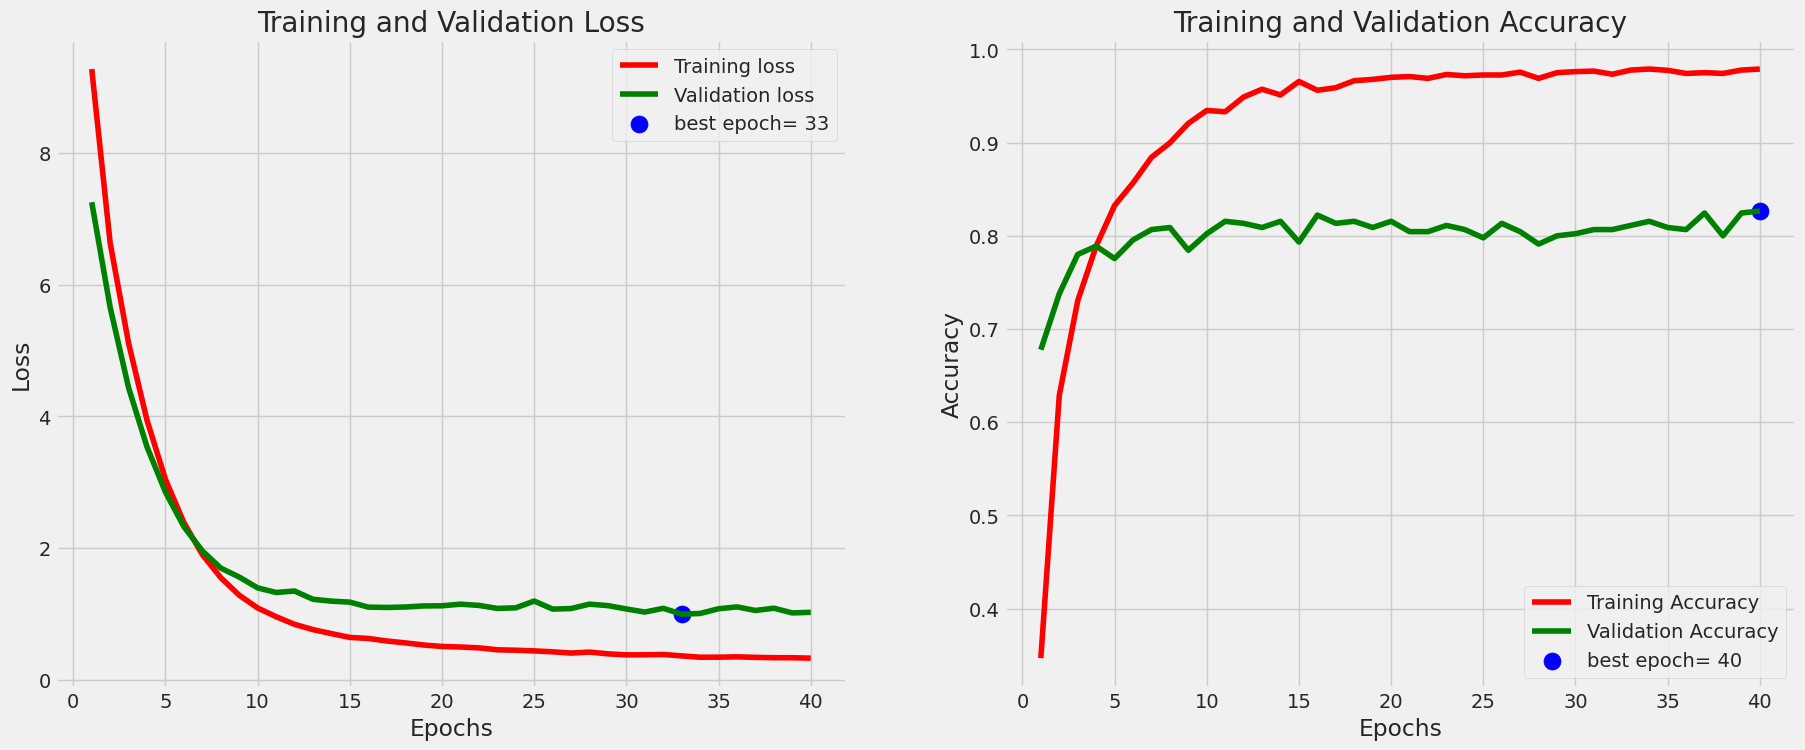

In [10]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

6/6 [==============================] - 190s 37s/step
there were 79 errors in 450 tests for an accuracy of  82.44


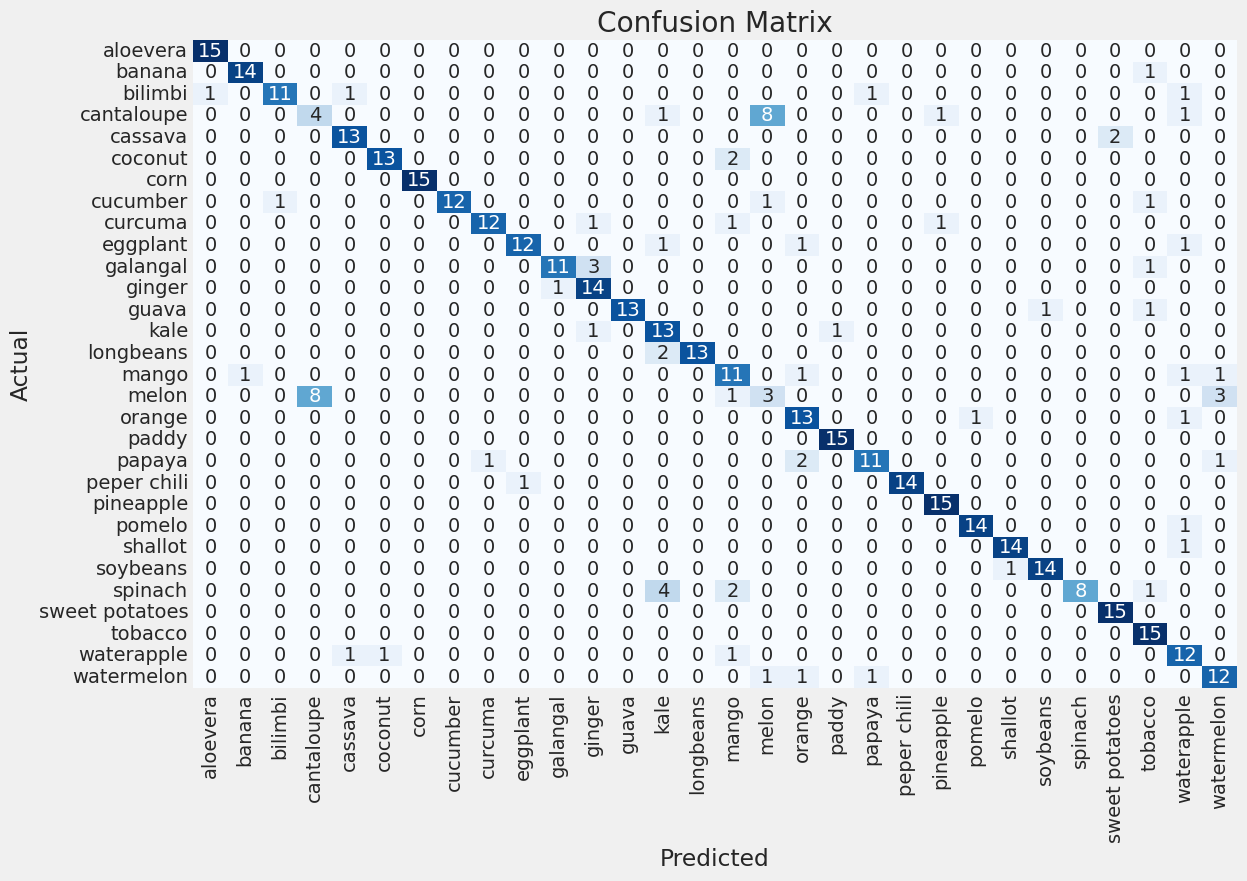

Classification Report:
----------------------
                 precision    recall  f1-score   support

      aloevera     0.9375    1.0000    0.9677        15
        banana     0.9333    0.9333    0.9333        15
       bilimbi     0.9167    0.7333    0.8148        15
    cantaloupe     0.3333    0.2667    0.2963        15
       cassava     0.8667    0.8667    0.8667        15
       coconut     0.9286    0.8667    0.8966        15
          corn     1.0000    1.0000    1.0000        15
      cucumber     1.0000    0.8000    0.8889        15
       curcuma     0.9231    0.8000    0.8571        15
      eggplant     0.9231    0.8000    0.8571        15
      galangal     0.9167    0.7333    0.8148        15
        ginger     0.7368    0.9333    0.8235        15
         guava     1.0000    0.8667    0.9286        15
          kale     0.6190    0.8667    0.7222        15
     longbeans     1.0000    0.8667    0.9286        15
         mango     0.6111    0.7333    0.6667        15


In [11]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

We achieved an F1 score of 83,6% which is not to bad considering we limited the number of images in train_df to 120  
images per class and reduced the image size to 200 X 260. This was done to reduce training time at the expense of the  
F1 score.

<a id="save"></a>
# <center>Save the model

In [12]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/')

subject='EfficientNetV2B2'
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as  ./EfficientNetV2B2_82.44.h5


<a id="implot"></a>
# <center>Create Plot of % change in validation loss for each epoch</center>
It is interesting to look at the percent reduction  in the validation loss for each epoch  
typically for the early epochs the percent improvement is fairly large for a good model  
then as epochs increase we will eventually see this value decrease or even go negative.  
I look at this percentage as an indicator when when to lower the learning rate or if the  
improvement continues to be negligable  for severable epochs to terminate training  
Note in the plot epoch 1 is not present since being the first epoch there is comparison  
with a previous epoch

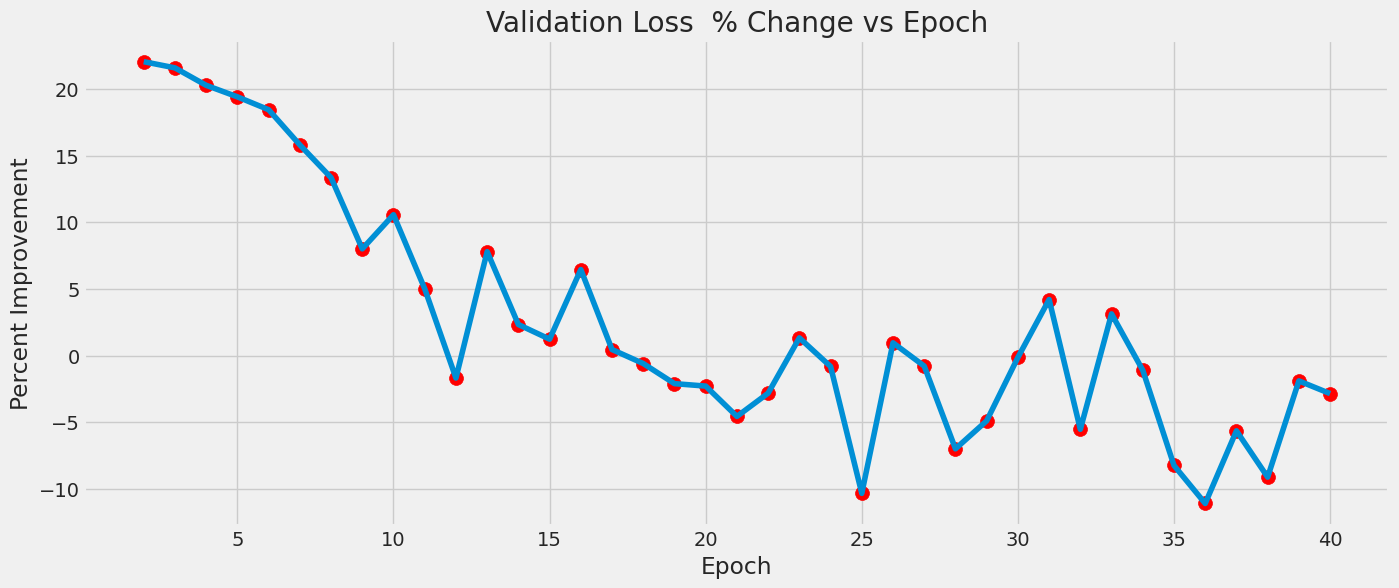

In [13]:
plist=ask.get_list() #   get the list of validation loss improvement per epoch
epochs=[]
for i in range(len(plist)):
    epochs.append(i + 2)
plt.figure(figsize=(15, 6))
plt.plot(epochs, plist)
plt.scatter(epochs, plist,s=100, color='r' )
plt.xlabel('Epoch')
plt.ylabel('Percent Improvement')
plt.title('Validation Loss  % Change vs Epoch')
plt.show()

<a id="analysis"></a>
# <center>Analysis of the Plot of % change in validation loss for each epoch</center>

I created the custom callback to provide useful information that can guide me to set the learning rate and detect    
over fitting. The callback monitors the validation loss for each epoch. When the validation loss for an epoch is    
lower than the lowest validation loss achieved thus far this lowest loss value and the associated weights of the    
model for that epoch are saved. At the end of training the model is loaded with these weights and consequently you  
do not have to worry about overfitting. One of the values I find useful that the callback provides is the percentage    
change in the validation loss for each epoch compared to the lowest validation loss achieved in the previous epochs.  
This is useful to help to decide if the learning rate needs to be reduced or if the model is starting to overfit.  
The plot above shows the percentage changes. Initially the learning rate was set to .001 and maintained at that level    
through epoch 10. As is typical for a good model and a good dataset we initially see fairly significant reduction    
in the validation in the early epochs. I like to think of the loss function as a parabaloid in N space where N is the    
number of trainable parameters. Initially we transverse down the parabaloid quickly in the early epochs. As we get  
further down the parabaloid is "width" narrows and  the slope of the surface becomes smaller. So typically with each    
epoch the percent improvement get smaller. The graph from epochs  2 throug 10 demonstrates that. At the end of epoch 10    
the % reduction in the validation loss was down to about 7 %. It might have been a good time to reduce the learning but    
I held it at .001 through epoch 15. We can see for epochs 13,14,15 the % improvement was getting near zero. So at epoch  
15 I changed the learning rate to .0005 and kept that value till epoch 20. That helped 16 but then again the % change    
started to trend near zero. In epoch 21 I change the learning rate down to ,0001. From epoch 21 through 25 the percent    
change remained below zero. This I believe is not the result of over fitting but that rather we have got down very near    
to the minimum achievable loss that our model is capable of. So small change in the weights have minimal effects on the loss    
If you look at the plot of validation loss and validation accuracy you can see that after epoch 10 there is very little    
improvement. Thats because the the slope of the loss function gets pretty small after 10 epochs which is an indicator  
that we are near the models minimum achieveable loss
